In [1]:
from IPython import display
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import time


# Import dataset

In [2]:
x_train = np.load('public_dataset.npy')
y_train = np.load('public_solution.npy')
x_compet = np.load('private_dataset.npy')


# Train - test split

To limit the lack of training samples for the first classes, the test set will not have any images for the first 15 classes. The test set is composed of 10 images from the 15th to the 1,000th class. 

In [3]:
data = [x_train[y_train == i] for i in range(100)] 
k = 10
start = 15
test_data = [data[i][:k] for i in range(start,len(data))]
train_data = data[:start] + [data[i][k:] for i in range(start,len(data))]
y_test = np.array([i for i in range(len(test_data)) for j in range(len(test_data[i]))]) +start
x_test = np.concatenate(test_data)

y_train = np.array([i for i in range(len(train_data)) for j in range(len(train_data[i]))]) 
x_train = np.concatenate(train_data)

# Visualisation

x_train (49650, 28, 28)
y_train (49650,)
x_compet (100000, 28, 28)


[]

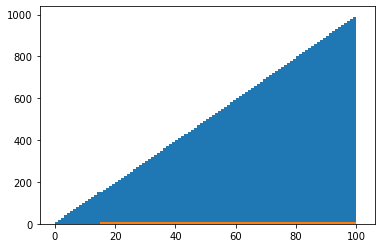

In [4]:
print("x_train",np.shape(x_train))
print("y_train",np.shape(y_train))
print("x_compet",np.shape(x_compet))
plt.hist(y_train,bins=range(102))
plt.plot()
plt.hist(y_test,bins=range(102))
plt.plot()

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
dic = dict(zip(unique, counts))
print(dic)

{0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 70, 7: 80, 8: 90, 9: 100, 10: 110, 11: 120, 12: 130, 13: 140, 14: 150, 15: 150, 16: 160, 17: 170, 18: 180, 19: 190, 20: 200, 21: 210, 22: 220, 23: 230, 24: 240, 25: 250, 26: 260, 27: 270, 28: 280, 29: 290, 30: 300, 31: 310, 32: 320, 33: 330, 34: 340, 35: 350, 36: 360, 37: 370, 38: 380, 39: 390, 40: 400, 41: 410, 42: 420, 43: 430, 44: 440, 45: 450, 46: 460, 47: 470, 48: 480, 49: 490, 50: 500, 51: 510, 52: 520, 53: 530, 54: 540, 55: 550, 56: 560, 57: 570, 58: 580, 59: 590, 60: 600, 61: 610, 62: 620, 63: 630, 64: 640, 65: 650, 66: 660, 67: 670, 68: 680, 69: 690, 70: 700, 71: 710, 72: 720, 73: 730, 74: 740, 75: 750, 76: 760, 77: 770, 78: 780, 79: 790, 80: 800, 81: 810, 82: 820, 83: 830, 84: 840, 85: 850, 86: 860, 87: 870, 88: 880, 89: 890, 90: 900, 91: 910, 92: 920, 93: 930, 94: 940, 95: 950, 96: 960, 97: 970, 98: 980, 99: 990}


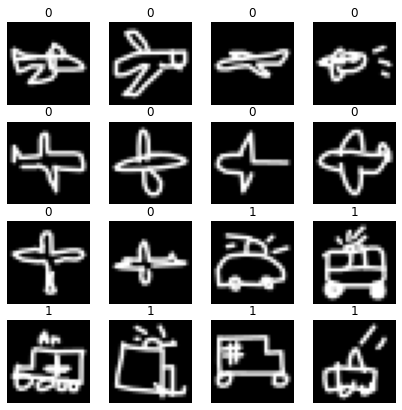

In [12]:
fig = plt.figure(figsize=(7,7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label=f"{y_train[i]}")
    plt.axis('off')
plt.show()

# Data augmentation

As the test set is balanced, the model should not be biased on the predicted classes because of the training distribution. To do that, the dataset is randomly augmented to have the exact same number of samples in each class. 

The dataset is augmented with random rotation, cropping, horizontal flipping and zooming. Each class is augmented until reaching 1,500 images per class.

In [13]:
x_train = np.reshape(x_train,(len(x_train),28,28,1))
x_test = np.reshape(x_test,(len(x_test),28,28,1))
x_compet = np.reshape(x_compet,(len(x_compet),28,28,1))

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0,
      horizontal_flip=True,
      vertical_flip=False,
      fill_mode='nearest')

#train_datagen.random_transform(image) pour appliquer une transfo
#image doit être de la forme (28,28,1)

# perform data augmentation
# data aug pour tripler le nombre d'images de chaque classe 
data = [x_train[y_train == i] for i in range(100)]
for ind in range(len(data)) :
    #print(ind)
    clas = data[ind]
    nb_base = np.shape(clas)[0]
    for _ in range(1500-np.shape(clas)[0]):
        nb = np.random.randint(0,nb_base)
        image = clas[nb]
        new_im = train_datagen.random_transform(image)
        data[ind] = np.append(data[ind],[new_im],axis=0)
y_train = np.array([i for i in range(len(data)) for j in range(len(data[i]))])
x_train = np.concatenate(data)

# Preprocessing 

One-hot encoding for labels et standardization for images

In [15]:
y_train = to_categorical(y_train)
x_train = x_train / 255 - 0.5 
y_test = to_categorical(y_test)
x_test = x_test / 255 - 0.5
x_compet = x_compet/ 255 - 0.5

In [16]:
print(np.shape(x_train))
print(np.shape(y_train))

(150000, 28, 28, 1)
(150000, 100)


In [17]:
#shuffle arrays
def shuffle_arrays(x_train,y_train):
    p = np.random.permutation(len(x_train))
    return x_train[p],y_train[p]

x_train,y_train = shuffle_arrays(x_train,y_train)
x_test,y_test = shuffle_arrays(x_test,y_test)

# Models

## Base CNN

In [18]:
def baseCNN():
    model = keras.Sequential()
    model.add(keras.Input(shape=(28, 28,1)))  
    model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
    model.add(layers.Conv2D(32, 3, activation="relu"))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(100,activation='softmax'))
    return model 

model = baseCNN()
#model.summary()


## ResNet

In [ ]:
from tensorflow.keras.models import Model

class Residual(layers.Layer):
    def __init__(self, n1, k1, s1, n2, k2, s2):
        super(Residual, self).__init__()
        self.conv1 = layers.Conv2D(n1,k1,strides =(s1,s1),padding='same')
        self.relu1 = layers.LeakyReLU()
        self.conv2 = layers.Conv2D(n2,k2,strides=(s2,s2),padding='same')
        self.add1 = layers.Add()
        self.relu2 = layers.LeakyReLU()
    def call(self,input):
        y = self.conv1(input)
        y = self.relu1(y)
        y = self.conv2(y)
        y = self.add1([input, y])
        y = self.relu2(y)
        return y 

def resnet():
    input_layer = layers.Input(shape=(28,28,1))
    y = layers.Conv2D(32,3,padding='valid')(input_layer)
    y = Residual(32,3,1,32,3,1)(y)
    y = layers.Conv2D(64,3,strides=(2,2),padding='valid')(y)
    y = Residual(64,3,1,64,3,1)(y)
    y = layers.Conv2D(128,3,strides=(2,2),padding='valid')(y)
    y = Residual(128,3,1,128,3,1)(y)
    y = layers.Conv2D(128,2,2)(y)
    y = layers.Conv2D(100,1,2)(y)
    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    return model

model = resnet()
#model.summary()

## MobileNet v2 

Many variations have been tested on this one. 

In [8]:
#mobile net v2 n°1 


#from typeguard import typechecked

class StochasticDepth(tf.keras.layers.Layer):
    """Stochastic Depth layer.
    Implements Stochastic Depth as described in
    [Deep Networks with Stochastic Depth](https://arxiv.org/abs/1603.09382), to randomly drop residual branches
    in residual architectures.
    Usage:
    Residual architectures with fixed depth, use residual branches that are merged back into the main network
    by adding the residual branch back to the input:
    >>> input = np.ones((1, 3, 3, 1), dtype = np.float32)
    >>> residual = tf.keras.layers.Conv2D(1, 1)(input)
    >>> output = tf.keras.layers.Add()([input, residual])
    >>> output.shape
    TensorShape([1, 3, 3, 1])
    StochasticDepth acts as a drop-in replacement for the addition:
    >>> input = np.ones((1, 3, 3, 1), dtype = np.float32)
    >>> residual = tf.keras.layers.Conv2D(1, 1)(input)
    >>> output = tfa.layers.StochasticDepth()([input, residual])
    >>> output.shape
    TensorShape([1, 3, 3, 1])
    At train time, StochasticDepth returns:
    $$
    x[0] + b_l * x[1],
    $$
    where $b_l$ is a random Bernoulli variable with probability $P(b_l = 1) = p_l$
    At test time, StochasticDepth rescales the activations of the residual branch based on the survival probability ($p_l$):
    $$
    x[0] + p_l * x[1]
    $$
    Args:
        survival_probability: float, the probability of the residual branch being kept.
    Call Args:
        inputs:  List of `[shortcut, residual]` where `shortcut`, and `residual` are tensors of equal shape.
    Output shape:
        Equal to the shape of inputs `shortcut`, and `residual`
    """

    #@typechecked
    def __init__(self, survival_probability: float = 0.5, **kwargs):
        super().__init__(**kwargs)

        self.survival_probability = survival_probability

    def call(self, x, training=None):
        if not isinstance(x, list) or len(x) != 2:
            raise ValueError("input must be a list of length 2.")

        shortcut, residual = x

        # Random bernoulli variable indicating whether the branch should be kept or not or not
        b_l = tf.keras.backend.random_bernoulli(
            [], p=self.survival_probability, dtype=self._compute_dtype_object
        )

        def _call_train():
            return shortcut + b_l * residual

        def _call_test():
            return shortcut + self.survival_probability * residual

        return tf.keras.backend.in_train_phase(
            _call_train, _call_test, training=training
        )

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        base_config = super().get_config()

        config = {"survival_probability": self.survival_probability}

        return {**base_config, **config}



def mobile_big():
    wd = 4e-5

    class Bottleneck(layers.Layer):
        def __init__(self,input_filters,output_filters,expansion,stride):
            super(Bottleneck, self).__init__()
            self.conv1 = layers.Conv2D(input_filters*expansion,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv2 = layers.DepthwiseConv2D(3,strides=(stride,stride),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv3 = layers.Conv2D(output_filters,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            self.drop1 = layers.Dropout(0.3)
            self.drop2 = layers.Dropout(0.3)

            if stride == 1 :
                self.add1 = StochasticDepth(0.8)
            if input_filters != output_filters :
                self.conv4 = layers.Conv2D(output_filters,1,strides=(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))

            self.input_filters = input_filters
            self.output_filters = output_filters
            self.stride = stride 
        
        def get_config(self):
        
            config = super().get_config().copy()
            config.update({
                'input_filters': self.input_filters,
                'output_filters': self.output_filters,
                'stride': self.stride
            })
            return config

        def call(self,input1):
            input2 = input1
            y = self.conv1(input1)
            y = self.bn1(y)
            y = tf.nn.relu6(y)
            y = self.drop1(y)
            y = self.conv2(y)
            y = self.bn2(y)
            y = tf.nn.relu6(y)
            y = self.drop2(y)
            y = self.conv3(y)
            if self.stride == 2 :
                return y 
            else :
                if self.input_filters != self.output_filters :
                    input2 = self.conv4(input2)

            y = self.add1([input2,y])
            return y 


    def BottleneckBlock(inputs,output_filters,expansion,stride,repeat):
        y = inputs
        input_filters = y.shape[3]
        if repeat == 1:
            y=Bottleneck(input_filters,output_filters,expansion,stride)(y)
        else : 
            for i in range(repeat):
                if i == 0 :
                    y=Bottleneck(input_filters,input_filters,expansion,stride)(y)
                else : 
                    y=Bottleneck(input_filters,output_filters,expansion,1)(y)
                """
                elif i == repeat-1 :
                    bottle.append(Bottleneck(input_filters,output_filters,expansion,1))
                else :
                    bottle.append(Bottleneck(input_filters,input_filters,expansion,1))
                """
        return y 
        
        
    input_layer = layers.Input(shape=(28,28,1))

    y = layers.Conv2D(32,3,padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(input_layer)
    # (28,28,32)
    y = BottleneckBlock(inputs=y,output_filters=16,expansion=1,stride=1,repeat=1)
    # (28,28,16)
    y = BottleneckBlock(inputs=y,output_filters=24,expansion=6,stride=2,repeat=2) #2
    # (14,14,24)
    y = BottleneckBlock(inputs=y,output_filters=32,expansion=6,stride=2,repeat=3) #3
    # (7,7,32)
    y = BottleneckBlock(inputs=y,output_filters=64,expansion=6,stride=2,repeat=4) #4
    # (4,4,64)
    y = BottleneckBlock(inputs=y,output_filters=96,expansion=6,stride=1,repeat=3) #3
    # (4,4,96)
    y = BottleneckBlock(inputs=y,output_filters=160,expansion=6,stride=2,repeat=2) #2
    # (2,2,160)
    #y = layers.Conv2D(300,1,1)(y)
    y = layers.MaxPooling2D(pool_size=(2,2))(y)
    y = layers.Conv2D(100,1,1,kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(y)



    #verifier shape ici puis continuer l'implé

    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    #model.summary()
    return model

In [35]:
#mobile net v2 n°2
# all repeats are set to 1
def mobile2():
    class Bottleneck(layers.Layer):
        def __init__(self,input_filters,output_filters,expansion,stride):
            super(Bottleneck, self).__init__()
            self.conv1 = layers.Conv2D(input_filters*expansion,1,strides =(1,1),padding='same')
            self.conv2 = layers.DepthwiseConv2D(3,strides=(stride,stride),padding='same')
            self.conv3 = layers.Conv2D(output_filters,1,strides =(1,1),padding='same')
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            if stride == 1 :
                self.add1 = layers.Add()
            if input_filters != output_filters :
                self.conv4 = layers.Conv2D(output_filters,1,strides=(1,1),padding='same')

            self.input_filters = input_filters
            self.output_filters = output_filters
            self.stride = stride 
        
        def get_config(self):
        
            config = super().get_config().copy()
            config.update({
                'input_filters': self.input_filters,
                'output_filters': self.output_filters,
                'stride': self.stride
            })
            return config

        def call(self,input1):
            input2 = input1
            y = self.conv1(input1)
            y = self.bn1(y)
            y = tf.nn.relu6(y)
            y = self.conv2(y)
            y = self.bn2(y)
            y = tf.nn.relu6(y)
            y = self.conv3(y)
            if self.stride == 2 :
                return y 
            else :
                if self.input_filters != self.output_filters :
                    input2 = self.conv4(input2)

            y = self.add1([input2,y])
            return y 


    def BottleneckBlock(inputs,output_filters,expansion,stride,repeat):
        y = inputs
        input_filters = y.shape[3]
        if repeat == 1:
            y=Bottleneck(input_filters,output_filters,expansion,stride)(y)
        else : 
            for i in range(repeat):
                if i == 0 :
                    y=Bottleneck(input_filters,input_filters,expansion,stride)(y)
                else : 
                    y=Bottleneck(input_filters,output_filters,expansion,1)(y)
                """
                elif i == repeat-1 :
                    bottle.append(Bottleneck(input_filters,output_filters,expansion,1))
                else :
                    bottle.append(Bottleneck(input_filters,input_filters,expansion,1))
                """
        return y 
        
        
    input_layer = layers.Input(shape=(28,28,1))

    y = layers.Conv2D(32,3,padding='same')(input_layer)
    # (28,28,32)
    y = BottleneckBlock(inputs=y,output_filters=16,expansion=1,stride=1,repeat=1)
    # (28,28,16)
    y = BottleneckBlock(inputs=y,output_filters=24,expansion=6,stride=2,repeat=1) #2
    # (14,14,24)
    y = BottleneckBlock(inputs=y,output_filters=32,expansion=6,stride=2,repeat=1) #3
    # (7,7,32)
    y = BottleneckBlock(inputs=y,output_filters=64,expansion=6,stride=2,repeat=1) #4
    # (4,4,64)
    y = BottleneckBlock(inputs=y,output_filters=96,expansion=6,stride=1,repeat=1) #3
    # (4,4,96)
    y = BottleneckBlock(inputs=y,output_filters=160,expansion=6,stride=2,repeat=1) #2
    # (2,2,160)
    #y = layers.Conv2D(300,1,1)(y)
    y = layers.MaxPooling2D(pool_size=(2,2))(y)
    y = layers.Conv2D(100,1,1)(y)



    #verifier shape ici puis continuer l'implé

    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    return model 

model = mobile2()
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_311 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck_110 (Bottleneck)  (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_111 (Bottleneck)  (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_112 (Bottleneck)  (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_113 (Bottleneck)  (None, 4, 4, 64)          22144     
_________________________________________________________________
bottleneck_114 (Bottleneck)  (None, 4, 4, 96)        

In [11]:
#mobile net v2 n°3

def mobile3():
    class Bottleneck(layers.Layer):
        def __init__(self,input_filters,output_filters,expansion,stride):
            super(Bottleneck, self).__init__()
            self.conv1 = layers.Conv2D(input_filters*expansion,1,strides =(1,1),padding='same')
            self.conv2 = layers.DepthwiseConv2D(3,strides=(stride,stride),padding='same')
            self.conv3 = layers.Conv2D(output_filters,1,strides =(1,1),padding='same')
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            if stride == 1 :
                self.add1 = layers.Add()
            if input_filters != output_filters :
                self.conv4 = layers.Conv2D(output_filters,1,strides=(1,1),padding='same')

            self.input_filters = input_filters
            self.output_filters = output_filters
            self.stride = stride 
        
        def get_config(self):
        
            config = super().get_config().copy()
            config.update({
                'input_filters': self.input_filters,
                'output_filters': self.output_filters,
                'stride': self.stride
            })
            return config

        def call(self,input1):
            input2 = input1
            y = self.conv1(input1)
            y = self.bn1(y)
            y = tf.nn.relu6(y)
            y = self.conv2(y)
            y = self.bn2(y)
            y = tf.nn.relu6(y)
            y = self.conv3(y)
            if self.stride == 2 :
                return y 
            else :
                if self.input_filters != self.output_filters :
                    input2 = self.conv4(input2)

            y = self.add1([input2,y])
            return y 


    def BottleneckBlock(inputs,output_filters,expansion,stride,repeat):
        y = inputs
        input_filters = y.shape[3]
        if repeat == 1:
            y=Bottleneck(input_filters,output_filters,expansion,stride)(y)
        else : 
            for i in range(repeat):
                if i == 0 :
                    y=Bottleneck(input_filters,input_filters,expansion,stride)(y)
                else : 
                    y=Bottleneck(input_filters,output_filters,expansion,1)(y)
                """
                elif i == repeat-1 :
                    bottle.append(Bottleneck(input_filters,output_filters,expansion,1))
                else :
                    bottle.append(Bottleneck(input_filters,input_filters,expansion,1))
                """
        return y 
        
        
    input_layer = layers.Input(shape=(28,28,1))

    y = layers.Conv2D(32,3,padding='same')(input_layer)
    # (28,28,32)
    y = BottleneckBlock(inputs=y,output_filters=16,expansion=1,stride=1,repeat=1)
    # (28,28,16)
    y = BottleneckBlock(inputs=y,output_filters=24,expansion=6,stride=2,repeat=1) #2
    # (14,14,24)
    y = BottleneckBlock(inputs=y,output_filters=32,expansion=6,stride=2,repeat=1) #3
    # (7,7,32)
    y = BottleneckBlock(inputs=y,output_filters=64,expansion=6,stride=2,repeat=2) #4
    # (4,4,64)
    y = BottleneckBlock(inputs=y,output_filters=96,expansion=6,stride=1,repeat=1) #3
    # (4,4,96)
    y = BottleneckBlock(inputs=y,output_filters=160,expansion=6,stride=2,repeat=1) #2
    # (2,2,160)
    y = layers.MaxPooling2D(pool_size=(2,2))(y)
    y = layers.Conv2D(100,1,1)(y)




    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    return model 

model = mobile3()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck (Bottleneck)      (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_1 (Bottleneck)    (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_2 (Bottleneck)    (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_3 (Bottleneck)    (None, 4, 4, 32)          15968     
_________________________________________________________________
bottleneck_4 (Bottleneck)    (None, 4, 4, 64)         

In [30]:
#mobile net v2 n°4
# with weight decay 

def mobile4():
    wd = 4e-5

    class Bottleneck(layers.Layer):
        def __init__(self,input_filters,output_filters,expansion,stride):
            super(Bottleneck, self).__init__()
            self.conv1 = layers.Conv2D(input_filters*expansion,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv2 = layers.DepthwiseConv2D(3,strides=(stride,stride),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv3 = layers.Conv2D(output_filters,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            if stride == 1 :
                self.add1 = layers.Add()
            if input_filters != output_filters :
                self.conv4 = layers.Conv2D(output_filters,1,strides=(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))

            self.input_filters = input_filters
            self.output_filters = output_filters
            self.stride = stride 
        
        def get_config(self):
        
            config = super().get_config().copy()
            config.update({
                'input_filters': self.input_filters,
                'output_filters': self.output_filters,
                'stride': self.stride
            })
            return config

        def call(self,input1):
            input2 = input1
            y = self.conv1(input1)
            y = self.bn1(y)
            y = tf.nn.relu6(y)
            y = self.conv2(y)
            y = self.bn2(y)
            y = tf.nn.relu6(y)
            y = self.conv3(y)
            if self.stride == 2 :
                return y 
            else :
                if self.input_filters != self.output_filters :
                    input2 = self.conv4(input2)

            y = self.add1([input2,y])
            return y 


    def BottleneckBlock(inputs,output_filters,expansion,stride,repeat):
        y = inputs
        input_filters = y.shape[3]
        if repeat == 1:
            y=Bottleneck(input_filters,output_filters,expansion,stride)(y)
        else : 
            for i in range(repeat):
                if i == 0 :
                    y=Bottleneck(input_filters,input_filters,expansion,stride)(y)
                else : 
                    y=Bottleneck(input_filters,output_filters,expansion,1)(y)
                """
                elif i == repeat-1 :
                    bottle.append(Bottleneck(input_filters,output_filters,expansion,1))
                else :
                    bottle.append(Bottleneck(input_filters,input_filters,expansion,1))
                """
        return y 
        
        
    input_layer = layers.Input(shape=(28,28,1))

    y = layers.Conv2D(32,3,padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(input_layer)
    # (28,28,32)
    y = BottleneckBlock(inputs=y,output_filters=16,expansion=1,stride=1,repeat=1)
    # (28,28,16)
    y = BottleneckBlock(inputs=y,output_filters=24,expansion=6,stride=2,repeat=1) #2
    # (14,14,24)
    y = BottleneckBlock(inputs=y,output_filters=32,expansion=6,stride=2,repeat=1) #3
    # (7,7,32)
    y = BottleneckBlock(inputs=y,output_filters=64,expansion=6,stride=2,repeat=2) #4
    # (4,4,64)
    y = BottleneckBlock(inputs=y,output_filters=96,expansion=6,stride=1,repeat=1) #3
    # (4,4,96)
    y = BottleneckBlock(inputs=y,output_filters=160,expansion=6,stride=2,repeat=1) #2
    # (2,2,160)
    y = layers.MaxPooling2D(pool_size=(2,2))(y)
    y = layers.Conv2D(100,1,1,kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(y)




    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    return model 

model = mobile4()
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_269 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck_87 (Bottleneck)   (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_88 (Bottleneck)   (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_89 (Bottleneck)   (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_90 (Bottleneck)   (None, 4, 4, 32)          15968     
_________________________________________________________________
bottleneck_91 (Bottleneck)   (None, 4, 4, 64)        

In [8]:
#mobile net v2 n°5
# with weight decay
# Dropout set to 0.2

def mobile5():

    wd = 4e-5
    class Bottleneck(layers.Layer):
        def __init__(self,input_filters,output_filters,expansion,stride):
            super(Bottleneck, self).__init__()
            self.conv1 = layers.Conv2D(input_filters*expansion,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv2 = layers.DepthwiseConv2D(3,strides=(stride,stride),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv3 = layers.Conv2D(output_filters,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            self.drop1 = layers.Dropout(0.2)
            self.drop2 = layers.Dropout(0.2)

            if stride == 1 :
                self.add1 = layers.Add()
            if input_filters != output_filters :
                self.conv4 = layers.Conv2D(output_filters,1,strides=(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))

            self.input_filters = input_filters
            self.output_filters = output_filters
            self.stride = stride 
        
        def get_config(self):
        
            config = super().get_config().copy()
            config.update({
                'input_filters': self.input_filters,
                'output_filters': self.output_filters,
                'stride': self.stride
            })
            return config

        def call(self,input1):
            input2 = input1
            y = self.conv1(input1)
            y = self.bn1(y)
            y = tf.nn.relu6(y)
            y = self.drop1(y)
            y = self.conv2(y)
            y = self.bn2(y)
            y = tf.nn.relu6(y)
            y = self.drop2(y)
            y = self.conv3(y)
            if self.stride == 2 :
                return y 
            else :
                if self.input_filters != self.output_filters :
                    input2 = self.conv4(input2)

            y = self.add1([input2,y])
            return y 


    def BottleneckBlock(inputs,output_filters,expansion,stride,repeat):
        y = inputs
        input_filters = y.shape[3]
        if repeat == 1:
            y=Bottleneck(input_filters,output_filters,expansion,stride)(y)
        else : 
            for i in range(repeat):
                if i == 0 :
                    y=Bottleneck(input_filters,input_filters,expansion,stride)(y)
                else : 
                    y=Bottleneck(input_filters,output_filters,expansion,1)(y)
                """
                elif i == repeat-1 :
                    bottle.append(Bottleneck(input_filters,output_filters,expansion,1))
                else :
                    bottle.append(Bottleneck(input_filters,input_filters,expansion,1))
                """
        return y 
        
        
    input_layer = layers.Input(shape=(28,28,1))

    y = layers.Conv2D(32,3,padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(input_layer)
    # (28,28,32)
    y = BottleneckBlock(inputs=y,output_filters=16,expansion=1,stride=1,repeat=1)
    # (28,28,16)
    y = BottleneckBlock(inputs=y,output_filters=24,expansion=6,stride=2,repeat=1) #2
    # (14,14,24)
    y = BottleneckBlock(inputs=y,output_filters=32,expansion=6,stride=2,repeat=1) #3
    # (7,7,32)
    y = BottleneckBlock(inputs=y,output_filters=64,expansion=6,stride=2,repeat=2) #4
    # (4,4,64)
    y = BottleneckBlock(inputs=y,output_filters=96,expansion=6,stride=1,repeat=1) #3
    # (4,4,96)
    y = BottleneckBlock(inputs=y,output_filters=160,expansion=6,stride=2,repeat=1) #2
    # (2,2,160)
    y = layers.MaxPooling2D(pool_size=(2,2))(y)
    y = layers.Conv2D(100,1,1,kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(y)




    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    #model.summary()
    return model

In [9]:
#mobile net v2 n°6
# with weight decay
# dropout set to 0.3, really slow to train

def mobile6():
    wd = 4e-5


    class Bottleneck(layers.Layer):
        def __init__(self,input_filters,output_filters,expansion,stride):
            super(Bottleneck, self).__init__()
            self.conv1 = layers.Conv2D(input_filters*expansion,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv2 = layers.DepthwiseConv2D(3,strides=(stride,stride),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv3 = layers.Conv2D(output_filters,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            self.drop1 = layers.Dropout(0.3)
            self.drop2 = layers.Dropout(0.3)

            if stride == 1 :
                self.add1 = layers.Add()
            if input_filters != output_filters :
                self.conv4 = layers.Conv2D(output_filters,1,strides=(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))

            self.input_filters = input_filters
            self.output_filters = output_filters
            self.stride = stride 
        
        def get_config(self):
        
            config = super().get_config().copy()
            config.update({
                'input_filters': self.input_filters,
                'output_filters': self.output_filters,
                'stride': self.stride
            })
            return config

        def call(self,input1):
            input2 = input1
            y = self.conv1(input1)
            y = self.bn1(y)
            y = tf.nn.relu6(y)
            y = self.drop1(y)
            y = self.conv2(y)
            y = self.bn2(y)
            y = tf.nn.relu6(y)
            y = self.drop2(y)
            y = self.conv3(y)
            if self.stride == 2 :
                return y 
            else :
                if self.input_filters != self.output_filters :
                    input2 = self.conv4(input2)

            y = self.add1([input2,y])
            return y 


    def BottleneckBlock(inputs,output_filters,expansion,stride,repeat):
        y = inputs
        input_filters = y.shape[3]
        if repeat == 1:
            y=Bottleneck(input_filters,output_filters,expansion,stride)(y)
        else : 
            for i in range(repeat):
                if i == 0 :
                    y=Bottleneck(input_filters,input_filters,expansion,stride)(y)
                else : 
                    y=Bottleneck(input_filters,output_filters,expansion,1)(y)
                """
                elif i == repeat-1 :
                    bottle.append(Bottleneck(input_filters,output_filters,expansion,1))
                else :
                    bottle.append(Bottleneck(input_filters,input_filters,expansion,1))
                """
        return y 
        
        
    input_layer = layers.Input(shape=(28,28,1))

    y = layers.Conv2D(32,3,padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(input_layer)
    # (28,28,32)
    y = BottleneckBlock(inputs=y,output_filters=16,expansion=1,stride=1,repeat=1)
    # (28,28,16)
    y = BottleneckBlock(inputs=y,output_filters=24,expansion=6,stride=2,repeat=1) #2
    # (14,14,24)
    y = BottleneckBlock(inputs=y,output_filters=32,expansion=6,stride=2,repeat=1) #3
    # (7,7,32)
    y = BottleneckBlock(inputs=y,output_filters=64,expansion=6,stride=2,repeat=2) #4
    # (4,4,64)
    y = BottleneckBlock(inputs=y,output_filters=96,expansion=6,stride=1,repeat=1) #3
    # (4,4,96)
    y = BottleneckBlock(inputs=y,output_filters=160,expansion=6,stride=2,repeat=1) #2
    # (2,2,160)
    y = layers.MaxPooling2D(pool_size=(2,2))(y)
    y = layers.Conv2D(100,1,1,kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(y)




    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    #model.summary()
    return model 

In [10]:
#mobile net v2 n°7
# with weight decay
# with drop channel set to 0.2 

def mobile7():

    wd = 4e-5


    class Bottleneck(layers.Layer):
        def __init__(self,input_filters,output_filters,expansion,stride):
            super(Bottleneck, self).__init__()
            self.conv1 = layers.Conv2D(input_filters*expansion,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv2 = layers.DepthwiseConv2D(3,strides=(stride,stride),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.conv3 = layers.Conv2D(output_filters,1,strides =(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            self.drop1 = layers.SpatialDropout2D(0.2)
            self.drop2 = layers.SpatialDropout2D(0.2)

            if stride == 1 :
                self.add1 = layers.Add()
            if input_filters != output_filters :
                self.conv4 = layers.Conv2D(output_filters,1,strides=(1,1),padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))

            self.input_filters = input_filters
            self.output_filters = output_filters
            self.stride = stride 
        
        def get_config(self):
        
            config = super().get_config().copy()
            config.update({
                'input_filters': self.input_filters,
                'output_filters': self.output_filters,
                'stride': self.stride
            })
            return config

        def call(self,input1):
            input2 = input1
            y = self.conv1(input1)
            y = self.bn1(y)
            y = tf.nn.relu6(y)
            y = self.drop1(y)
            y = self.conv2(y)
            y = self.bn2(y)
            y = tf.nn.relu6(y)
            y = self.drop2(y)
            y = self.conv3(y)
            if self.stride == 2 :
                return y 
            else :
                if self.input_filters != self.output_filters :
                    input2 = self.conv4(input2)

            y = self.add1([input2,y])
            return y 


    def BottleneckBlock(inputs,output_filters,expansion,stride,repeat):
        y = inputs
        input_filters = y.shape[3]
        if repeat == 1:
            y=Bottleneck(input_filters,output_filters,expansion,stride)(y)
        else : 
            for i in range(repeat):
                if i == 0 :
                    y=Bottleneck(input_filters,input_filters,expansion,stride)(y)
                else : 
                    y=Bottleneck(input_filters,output_filters,expansion,1)(y)
                """
                elif i == repeat-1 :
                    bottle.append(Bottleneck(input_filters,output_filters,expansion,1))
                else :
                    bottle.append(Bottleneck(input_filters,input_filters,expansion,1))
                """
        return y 
        
        
    input_layer = layers.Input(shape=(28,28,1))

    y = layers.Conv2D(32,3,padding='same',kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(input_layer)
    # (28,28,32)
    y = BottleneckBlock(inputs=y,output_filters=16,expansion=1,stride=1,repeat=1)
    # (28,28,16)
    y = BottleneckBlock(inputs=y,output_filters=24,expansion=6,stride=2,repeat=1) #2
    # (14,14,24)
    y = BottleneckBlock(inputs=y,output_filters=32,expansion=6,stride=2,repeat=1) #3
    # (7,7,32)
    y = BottleneckBlock(inputs=y,output_filters=64,expansion=6,stride=2,repeat=2) #4
    # (4,4,64)
    y = BottleneckBlock(inputs=y,output_filters=96,expansion=6,stride=1,repeat=1) #3
    # (4,4,96)
    y = BottleneckBlock(inputs=y,output_filters=160,expansion=6,stride=2,repeat=1) #2
    # (2,2,160)
    y = layers.MaxPooling2D(pool_size=(2,2))(y)
    y = layers.Conv2D(100,1,1,kernel_regularizer=regularizers.l2(wd), bias_regularizer=regularizers.l2(wd))(y)




    y = layers.Reshape((100,))(y)
    y = tf.keras.activations.softmax(y, axis=-1)
    model = Model(input_layer,y)
    #model.summary()
    return model

In [31]:
model.save('weights.h5')

Mon test set est constitué de 10 images de 85 classes 
Une accuracy acc sur ce test set conduit à une accuracy réelle sur un dataset equilibré de 
85/100 * acc + potentiellement 15% inconnus comme on n'a pas d'image de test pour cette partie 





Quelques exemples de valeurs :  

val_acc = 67% -> 56% réel 

val_acc = 70% -> 59.5% réel 

val_acc = 76.5% -> 65% réel 

val_acc = 82.35% -> 70% réel 

Attention, ce sont des valeurs minimales donc on peut espérer un peu plus :)

Benchmarck  

Val acc : 70%, 8 époques, resnet, data_aug de façon à avoir 1000 images dans chaque classe

Val acc : 70% tout pareil, Data aug que sur le dataset reel 

Val acc : 70% tout pareil, mais data aug de façon à tripler le dataset d'entrainement mais à nuancer pcq probablement moins bon sur les 15 premières classes 

val acc : 69.5%, 9 époques, data aug poupr tripler le dataset, MobileNetV2

Few shot learning -> de la merde.

j'ai fait beaucoup de tests ensuite avec mobilenet 
globalement, j'ai des résultats autour de 70% pour toutes les archis en faisant varier les couches de mobilenetv2. Seul le modèle avec 687k paramètres donne des résultats meilleurs à 73%. Le reste a 300k param et tourne autour de 70%. Néanmoins, tous mes modèles overfittent très salement.
J'essaie alors d'utiliser plein de techniques annexes pour augmenter mes perfs.
Label smoothing me fait gagner un peu
La régularisation retire l'overfit de départ et donne l'impression d'avoir un entrainement avec moins d'overfit 
Je passe ensuite au Dropout. Plusieurs choses à tester : droupout normal avec p à faire varier et dropout channel. La durée de l'entrainement explose mais j'obtiens de bien meilleurs résultats à la fin pour dropout(0.2) -> j'arrive à 76% 

Enfin, dernière, technique, je fais la moyenne des prédictions sur 6 modèles et j'arrive à 77% de val.

Idées sur le modèle :     
- Mettre du Dropout, drop block ou drop filter ou drop connect ou stockastic depth
- Simplifier le modèle 
- changer MaxPooling en AveragePooling 
- Augmenter taille avant MaxPooling : ne fonctionne pas 


Une fois que modèle choisi :     
- Faire du label smoothing -> gagne 3% sur mobilenet3 
    0.1 : mieux que 1.5
- Déséquilibrer la loss 
- Augmenter le nb de données des grosses classes -> avoir encore plus d'images pour moins overfiter (faire recherches sur la data aug et ses limites)
- mettre de la régularisation -> mettre du weight decay sur toutes les couches 
- Optimizer RMSProp : résultats similaires

Pousser l'entrainement à fond :      
- Early Stopping 
- Learning rate : à priori inutile pcq le problème est l'overfitting ici

# Training

In [41]:
# Reduce LR on plateau is not relevant as the model always overfits

# rlr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.7, patience=3, verbose=0,
#     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


# opt = tf.keras.optimizers.RMSprop(
#     learning_rate=0.045,
#     rho=0.9,
#     momentum=0.9,
#     epsilon=1e-07,
#     centered=False,
#     name="RMSprop")

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=opt, 
              loss=loss, 
              metrics=['accuracy'])

checkpoint_filepath = 'weights.{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#model.load_weights('file')

history = model.fit(x_train, y_train, batch_size = 256 ,epochs=60,validation_data=(x_test,y_test),callbacks = [model_checkpoint_callback])
#history = model.fit(x_train[:2], y_train[:2], batch_size = 2 ,epochs=10000,validation_data=(x_train[:2], y_train[:2]),callbacks = [rlr])



Epoch 1/60
586/586 [==============================] - 113s 193ms/step - loss: 4.2584 - accuracy: 0.0862 - val_loss: 4.7734 - val_accuracy: 0.0200
Epoch 2/60
586/586 [==============================] - 104s 178ms/step - loss: 3.6181 - accuracy: 0.2191 - val_loss: 3.0884 - val_accuracy: 0.3588
Epoch 3/60
586/586 [==============================] - 95s 162ms/step - loss: 3.3602 - accuracy: 0.2829 - val_loss: 2.8105 - val_accuracy: 0.4412
Epoch 4/60
586/586 [==============================] - 94s 160ms/step - loss: 3.1691 - accuracy: 0.3339 - val_loss: 2.6402 - val_accuracy: 0.4965
Epoch 5/60
586/586 [==============================] - 93s 158ms/step - loss: 3.0026 - accuracy: 0.3794 - val_loss: 2.4869 - val_accuracy: 0.5329
Epoch 6/60
586/586 [==============================] - 94s 161ms/step - loss: 2.8763 - accuracy: 0.4148 - val_loss: 2.4250 - val_accuracy: 0.5600
Epoch 7/60
586/586 [==============================] - 95s 161ms/step - loss: 2.7902 - accuracy: 0.4406 - val_loss: 2.3358 - val_

In [88]:
### Resume the training of multiple models

create_model = [mobile5,mobile6,mobile7]
previous = ['last_mob5_120.h5',"last_mob6_120.h5","last_mob7_120.h5"]
name = ["mob5","mob6","mob7"]

for i in range(len(create_model)):
    model = create_model[i]()
    opt = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=opt, 
                loss=loss, 
                metrics=['accuracy'])
    model.load_weights(previous[i])
    checkpoint_filepath = name[i]+'.120+{epoch:02d}-{val_accuracy:.4f}-{accuracy:.4f}.h5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    history = model.fit(x_train, y_train, batch_size = 256 ,epochs=60,validation_data=(x_test,y_test),callbacks = [model_checkpoint_callback])
    model.save_weights('last_'+name[i]+'_180.h5')


Epoch 1/60
586/586 [==============================] - 107s 182ms/step - loss: 1.8737 - accuracy: 0.7224 - val_loss: 1.8457 - val_accuracy: 0.7600
Epoch 2/60
586/586 [==============================] - 100s 171ms/step - loss: 1.8525 - accuracy: 0.7273 - val_loss: 1.8364 - val_accuracy: 0.7482
Epoch 3/60
586/586 [==============================] - 97s 165ms/step - loss: 1.8442 - accuracy: 0.7293 - val_loss: 1.8232 - val_accuracy: 0.7529
Epoch 4/60
586/586 [==============================] - 96s 165ms/step - loss: 1.8386 - accuracy: 0.7315 - val_loss: 1.8801 - val_accuracy: 0.7141
Epoch 5/60
586/586 [==============================] - 97s 165ms/step - loss: 1.8351 - accuracy: 0.7324 - val_loss: 1.8211 - val_accuracy: 0.7588
Epoch 6/60
586/586 [==============================] - 97s 165ms/step - loss: 1.8328 - accuracy: 0.7331 - val_loss: 1.8564 - val_accuracy: 0.7600
Epoch 7/60
586/586 [==============================] - 96s 165ms/step - loss: 1.8282 - accuracy: 0.7331 - val_loss: 1.8705 - val_

In [11]:
def evaluate_pred(y_pred,y_test):
    eq = tf.math.equal(tf.argmax(y_pred,axis=-1),tf.argmax(y_test,axis=-1)) 
    acc = tf.reduce_sum(tf.cast(eq,tf.float32))/tf.cast(tf.shape(y_test)[0],tf.float32)
    print(acc.numpy())

evaluate_pred(model(x_test,training=False),y_test)



# Self Supervised Learning with noisy student learning

As there are 100,000 test data that are unlabeled, we can use it to have more training samples. To do that, I used my current best model to generate pseudo-labels and then only retained the predictions with the highest confidence score. 

## Creating pseudo labels

In [25]:
y_pred = model(x_compet, training=False)
pseudo_labels = tf.argmax(y_pred,axis=-1)
pseudo_labels= np.array(pseudo_labels)
y_pred = np.array(y_pred)

print(tf.shape(pseudo_labels))
print(pseudo_labels)

np.save("pseudo_labels", pseudo_labels)
np.save("pseudo_pred", y_pred)

tf.Tensor([100000], shape=(1,), dtype=int32)
[42 53  9 ... 77  2 49]


## Visualization of pseudo labels distribution

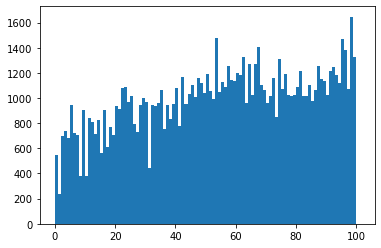

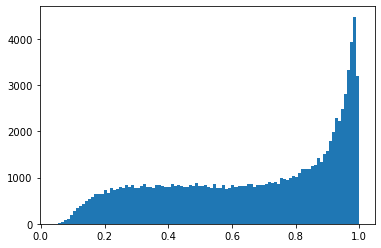

(77895, 28, 28, 1)
(77895,)


In [10]:
pred = np.load("pseudo_pred.npy")
pseudo_labels = np.load("pseudo_labels.npy")

pred = np.max(pred, axis=-1)

plt.hist(pseudo_labels, bins=range(102))
plt.show()

plt.hist(pred,bins = 100)
plt.show()


## Creation of the new augmented dataset containing pseudo labels

Random augmentation is until 4,000 images in each class.

In [ ]:
x_train2 = x_compet[pred>0.4]
y_train2 = pseudo_labels[pred>0.4]

print(np.shape(x_train2))
print(np.shape(y_train2))

x_train_tot = np.concatenate((x_train,x_train2))
y_train_tot = np.concatenate((y_train,y_train2))

In [9]:
number = [np.sum(y_train_tot==i) for i in range(100)]
print(number)

[329, 200, 514, 585, 634, 941, 606, 677, 337, 898, 343, 778, 790, 662, 767, 506, 686, 632, 836, 753, 950, 985, 1133, 1134, 1119, 380, 971, 728, 1139, 1194, 1176, 524, 964, 895, 1083, 1289, 925, 1238, 1083, 1179, 1073, 935, 1387, 1246, 1204, 1313, 1189, 1411, 1478, 1328, 1405, 1374, 1197, 1833, 1502, 1291, 1478, 1686, 1439, 1668, 1393, 1086, 1591, 1366, 1569, 1530, 1754, 1303, 1575, 1662, 1179, 1545, 1636, 1316, 1702, 1670, 1625, 1610, 1638, 1746, 1735, 1742, 1669, 1735, 1825, 1711, 1640, 1848, 1948, 1896, 1786, 1840, 1986, 1936, 1922, 1762, 1826, 1872, 2427, 1943]


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0,
      horizontal_flip=True,
      vertical_flip=False,
      fill_mode='nearest')

#train_datagen.random_transform(image) pour appliquer une transfo
#image doit être de la forme (28,28,1)

# perform data augmentation
# data aug pour tripler le nombre d'images de chaque classe 
data = [x_train_tot[y_train_tot == i] for i in range(100)]
for ind in range(len(data)) :
    #print(ind)
    clas = data[ind]
    nb_base = np.shape(clas)[0]
    for _ in range(4000-np.shape(clas)[0]):
        nb = np.random.randint(0,nb_base)
        image = clas[nb]
        new_im = train_datagen.random_transform(image)
        data[ind] = np.append(data[ind],[new_im],axis=0)
y_train_tot = np.array([i for i in range(len(data)) for j in range(len(data[i]))])
x_train_tot = np.concatenate(data)

In [12]:
y_train_tot = to_categorical(y_train_tot)
x_train_tot = x_train_tot / 255 - 0.5 # centering
y_test = to_categorical(y_test)
x_test = x_test / 255 - 0.5
x_compet = x_compet/ 255 - 0.5

def shuffle_arrays(x_train,y_train):
    p = np.random.permutation(len(x_train))
    return x_train[p],y_train[p]
x_train_tot,y_train_tot = shuffle_arrays(x_train_tot,y_train_tot)
x_test,y_test = shuffle_arrays(x_test,y_test)

In [13]:
### Training

create_model = [mobile_big]
#previous = ['mobile_big.37-0.7247-0.7180.h5']
name = ["mobile_big"]

for i in range(len(create_model)):
    model = create_model[i]()
    opt = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=opt, 
                loss=loss, 
                metrics=['accuracy'])
    #model.load_weights(previous[i])
    checkpoint_filepath = name[i]+'.{epoch:02d}-{val_accuracy:.4f}-{accuracy:.4f}.h5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    history = model.fit(x_train_tot, y_train_tot, batch_size = 256 ,epochs=60,validation_data=(x_test,y_test),callbacks = [model_checkpoint_callback],initial_epoch=0,steps_per_epoch=600)
    model.save_weights('last_'+name[i]+'_60.h5')


Instructions for updating:
Use `tf.keras.backend.random_bernoulli` instead.
Epoch 1/60
600/600 [==============================] - 157s 262ms/step - loss: 4.4157 - accuracy: 0.0636 - val_loss: 4.0968 - val_accuracy: 0.1106
Epoch 2/60
600/600 [==============================] - 153s 255ms/step - loss: 3.6695 - accuracy: 0.1990 - val_loss: 3.5790 - val_accuracy: 0.2624
Epoch 3/60
362/600 [=================>............] - ETA: 1:00 - loss: 3.4273 - accuracy: 0.2596

# Des pistes en plus 

- avoir Trois modèles côte à côte et faire du dropout 0.3 au bout des trois pour en entrainer 1 seul à chaque fois
- LDA après MaxPooling 
- mettre des Denses sur trois modèles non entrainables pour trouver la meilleure régression (retirer le softmax ou pas)

# MobileNet as a Features extractor

## Linear Discriminant analysis mobilenet

In [14]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck (Bottleneck)      (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_1 (Bottleneck)    (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_2 (Bottleneck)    (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_3 (Bottleneck)    (None, 4, 4, 32)          15968     
_________________________________________________________________
bottleneck_4 (Bottleneck)    (None, 4, 4, 64)         

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import sklearn.ensemble

In [35]:
output_max_pool = model.get_layer("bottleneck_6").output
trunc_model = Model(inputs=model.inputs,outputs=output_max_pool)
trunc_model.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck (Bottleneck)      (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_1 (Bottleneck)    (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_2 (Bottleneck)    (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_3 (Bottleneck)    (None, 4, 4, 32)          15968     
_________________________________________________________________
bottleneck_4 (Bottleneck)    (None, 4, 4, 64)         

In [41]:
train_features = np.reshape(trunc_model.predict(x_train),(150000,-1))
test_features = np.reshape(trunc_model.predict(x_test),(850,-1))

print(np.shape(train_features))
print(np.shape(test_features))

(150000, 640)
(850, 640)


In [ ]:
for i in range(10,100,10):
    clf = LinearDiscriminantAnalysis(n_components=i)
    clf.fit(train_features, np.argmax(y_train,axis=-1))
    pred = clf.predict(test_features)
    print(i,"acc : ", np.sum(pred==np.argmax(y_test,axis=-1))/len(y_test))

Results with LDA are not as good as a simple MobileNet

## Gradient Boosting Mobilenet

In [ ]:
gb = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0,verbose=1)
gb.fit(train_features, np.argmax(y_train,axis=-1))
pred = gb.predict(test_features)
print("acc : ", np.sum(pred==np.argmax(y_test,axis=-1))/len(y_test))

GB is too slow to train

# Ensembles

## Weighted vote

In [ ]:
#best (soumis): 
"""
models_init = [mobile5,mobile6,mobile7,mobile5,mobile6,mobile7,mobile5,mobile6,mobile7]
weights = ["mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","mob7.110-0.7365-0.6424.h5", "last_mob5_120.h5","last_mob6_120.h5","last_mob7_120.h5",
            "mob5.56-0.7576.h5","mob6.60-0.7294.h5","mob7.59-0.7212.h5"]
"""
#0.7717647

#best 2 : 
"""
models_init = [mobile5,mobile6,mobile7,mobile5,mobile6,mobile7]#,mobile5,mobile6,mobile7]
weights = ["mob5.159-0.7659-0.7465.h5","mob6.158-0.7482-0.6675.h5","mob7.168-0.7494-0.6603.h5",
            "mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","mob7.110-0.7365-0.6424.h5"
            ]
"""
#0.7752941

pred = []
models = []

models_init = [mobile5,mobile6,mobile7,mobile5,mobile6,mobile7]#,mobile5,mobile6,mobile7]
weights = ["mob5.159-0.7659-0.7465.h5","mob6.158-0.7482-0.6675.h5","mob7.168-0.7494-0.6603.h5",
            "mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","mob7.110-0.7365-0.6424.h5"
            ]

for i in range(len(models_init)):
    models.append(models_init[i]())
    models[i].load_weights(weights[i])
    pred.append(models[i](x_test,training=False))
    print("model",i)
    evaluate_pred(pred[i],y_test)

moy = sum([mod.predict(x_test) for mod in models])/len(models)
evaluate_pred(moy,y_test)



model 0
0.7658824
model 1
0.7482353
model 2
0.74941176
model 3
0.7635294
model 4
0.74588233
model 5
0.7364706
0.7752941


## Meta learner

In [66]:
def dense_all():
    models_init = [mobile5,mobile6,mobile7,
                    mobile5,mobile6,mobile7]#,mobile5,mobile6,mobile7]
    weights = ["mob5.159-0.7659-0.7465.h5","mob6.158-0.7482-0.6675.h5","mob7.168-0.7494-0.6603.h5",
                "mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","mob7.110-0.7365-0.6424.h5"
                ]

    nb = len(models_init)
    #0.7752941

    input_layer = layers.Input(shape=(28,28,1))
    subs =[models_init[i]() for i in range(nb)]
   
    y =[]
    for i in range(nb):
        subs[i].load_weights(weights[i])
        subs[i].trainable = False
        y.append(subs[i](input_layer))
    y = layers.Concatenate()(y)
    y = layers.Dense(100,activation="softmax")(y)
    model = Model(inputs=input_layer,outputs=y)
    return model
model = dense_all()
model.summary()




Model: "functional_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_814 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck_259 (Bottleneck)  (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_260 (Bottleneck)  (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_261 (Bottleneck)  (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_262 (Bottleneck)  (None, 4, 4, 32)          15968     
_________________________________________________________________
bottleneck_263 (Bottleneck)  (None, 4, 4, 64)        

In [74]:
def dense_all_wo_softmax():
    models_init = [mobile5,mobile6,mobile7,
                    mobile5,mobile6,mobile7]#,mobile5,mobile6,mobile7]
    weights = ["mob5.159-0.7659-0.7465.h5","mob6.158-0.7482-0.6675.h5","mob7.168-0.7494-0.6603.h5",
                "mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","mob7.110-0.7365-0.6424.h5"
                ]

    nb = len(models_init)
    #0.7752941

    input_layer = layers.Input(shape=(28,28,1))
    subs =[models_init[i]() for i in range(nb)]
   
    y =[]
    for i in range(nb):
        subs[i].load_weights(weights[i])
        subs[i].trainable = False
        subs[i] = Model(subs[i].inputs,subs[i].layers[-2].output)
        y.append(subs[i](input_layer))
    #subs[0].summary()
    y = layers.Concatenate()(y)
    y = layers.Dense(100,activation="softmax")(y)
    model = Model(inputs=input_layer,outputs=y)
    return model
model = dense_all_wo_softmax()
model.summary()




Model: "functional_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1342 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck_427 (Bottleneck)  (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_428 (Bottleneck)  (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_429 (Bottleneck)  (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_430 (Bottleneck)  (None, 4, 4, 32)          15968     
_________________________________________________________________
bottleneck_431 (Bottleneck)  (None, 4, 4, 64)       

In [76]:
def dense_all_wo_softmax_dropout():
    models_init = [mobile5,mobile6,mobile7,
                    mobile5,mobile6,mobile7]#,mobile5,mobile6,mobile7]
    weights = ["mob5.159-0.7659-0.7465.h5","mob6.158-0.7482-0.6675.h5","mob7.168-0.7494-0.6603.h5",
                "mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","mob7.110-0.7365-0.6424.h5"
                ]

    nb = len(models_init)
    #0.7752941

    input_layer = layers.Input(shape=(28,28,1))
    subs =[models_init[i]() for i in range(nb)]
   
    y =[]
    for i in range(nb):
        subs[i].load_weights(weights[i])
        subs[i].trainable = False
        subs[i] = Model(subs[i].inputs,subs[i].layers[-2].output)
        y.append(subs[i](input_layer))
    #subs[0].summary()
    y = layers.Concatenate()(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(100,activation="softmax")(y)
    model = Model(inputs=input_layer,outputs=y)
    return model
model = dense_all_wo_softmax_dropout()
model.summary()




Model: "functional_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1474 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
bottleneck_469 (Bottleneck)  (None, 28, 28, 16)        2688      
_________________________________________________________________
bottleneck_470 (Bottleneck)  (None, 14, 14, 24)        5688      
_________________________________________________________________
bottleneck_471 (Bottleneck)  (None, 7, 7, 32)          10832     
_________________________________________________________________
bottleneck_472 (Bottleneck)  (None, 4, 4, 32)          15968     
_________________________________________________________________
bottleneck_473 (Bottleneck)  (None, 4, 4, 64)       

In [ ]:
def dense_all_wo_softmax_dropout():
    models_init = [mobile5,mobile6,mobile7,
                    mobile5,mobile6,mobile7]
    weights = ["mob5.159-0.7659-0.7465.h5","mob6.158-0.7482-0.6675.h5","mob7.168-0.7494-0.6603.h5",
                "mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","mob7.110-0.7365-0.6424.h5"
                ]

    nb = len(models_init)
    #0.7752941

    input_layer = layers.Input(shape=(28,28,1))
    subs =[models_init[i]() for i in range(nb)]
   
    y =[]
    for i in range(nb):
        subs[i].load_weights(weights[i])
        subs[i].trainable = False
        subs[i] = Model(subs[i].inputs,subs[i].layers[-2].output)
        y.append(subs[i](input_layer))
    #subs[0].summary()
    y = layers.Concatenate()(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(100,activation="softmax")(y)
    model = Model(inputs=input_layer,outputs=y)
    return model
model = dense_all_wo_softmax_dropout()
model.summary()




In [ ]:
def dense_all_wo_softmax_dropout2():
    models_init = [mobile5,mobile6,mobile7,
                    mobile5,mobile6,mobile5]
    weights = ["mob5.159-0.7659-0.7465.h5","mob6.158-0.7482-0.6675.h5","mob7.168-0.7494-0.6603.h5",
                "mob5.118-0.7635-0.7393.h5","mob6.106-0.7459-0.6574.h5","n2_mob5.100-0.7682-0.7933.h5"
                ]

    nb = len(models_init)
    #0.7752941

    input_layer = layers.Input(shape=(28,28,1))
    subs =[models_init[i]() for i in range(nb)]
   
    y =[]
    for i in range(nb):
        subs[i].load_weights(weights[i])
        subs[i].trainable = False
        subs[i] = Model(subs[i].inputs,subs[i].layers[-2].output)
        y.append(subs[i](input_layer))
    #subs[0].summary()
    y = layers.Concatenate()(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(100,activation="softmax")(y)
    model = Model(inputs=input_layer,outputs=y)
    return model
model = dense_all_wo_softmax_dropout()
model.summary()




In [77]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
#model.load_weights()
model.compile(optimizer=opt, 
            loss=loss, 
            metrics=['accuracy'])
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.7, patience=3, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


checkpoint_filepath = 'best_of_all_wo_softmax_dropout2.{epoch:02d}-{val_accuracy:.4f}-{accuracy:.4f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(x_train, y_train, batch_size = 256 ,epochs=100,validation_data=(x_test,y_test),callbacks = [model_checkpoint_callback,rlr],initial_epoch=0,steps_per_epoch=100)

Epoch 1/100
100/100 [==============================] - 52s 522ms/step - loss: 4.1635 - accuracy: 0.3724 - val_loss: 2.8369 - val_accuracy: 0.6988
Epoch 2/100
100/100 [==============================] - 36s 357ms/step - loss: 3.0445 - accuracy: 0.5950 - val_loss: 2.7102 - val_accuracy: 0.7353
Epoch 3/100
100/100 [==============================] - 37s 369ms/step - loss: 2.8685 - accuracy: 0.6431 - val_loss: 2.6455 - val_accuracy: 0.7553
Epoch 4/100
100/100 [==============================] - 36s 365ms/step - loss: 2.7616 - accuracy: 0.6730 - val_loss: 2.6353 - val_accuracy: 0.7565
Epoch 5/100
100/100 [==============================] - 37s 366ms/step - loss: 2.6895 - accuracy: 0.6868 - val_loss: 2.6067 - val_accuracy: 0.7576
Epoch 6/100
100/100 [==============================] - 37s 366ms/step - loss: 2.6511 - accuracy: 0.6938 - val_loss: 2.5809 - val_accuracy: 0.7706
Epoch 7/100
100/100 [==============================] - 36s 358ms/step - loss: 2.5978 - accuracy: 0.7057 - val_loss: 2.5670 -

KeyboardInterrupt: 

In [ ]:
model = dense_all_wo_softmax_dropout()
model.load_weights("best_of_all_wo_softmax_dropout.27-0.7906-0.7396.h5")
evaluate_pred(model.predict(x_test),y_test)

prediction = model.predict(x_compet)
np.save("prediction.npy", prediction)
print(np.shape(x_compet))
print(np.shape(prediction))

In [60]:
model.save_weights("best_of_all.61-0.7788-0.7826.h5")